In [1]:
# Cormac Greaney / 22352228 & Jan Lawinski / 22340343
# The code does execute to the end without error 
# Placeholer for links to third party implementations

In [2]:
# ============================================================
# Installation Cell
# ------------------------------------------------------------
# These pip commands install everything required for this
# notebook to run on a fresh machine
# ============================================================

# --- Core RL + Atari dependencies ---
#!pip install "gymnasium[atari,accept-rom-license]"
#!pip install ale-py

# --- Numerical + plotting utilities ---
#!pip install numpy
#!pip install matplotlib

# --- Image processing for preprocessing frames ---
#!pip install opencv-python

# --- Deep learning framework (we're using PyTorch) ---
#!pip install torch

# --- (Optional) If you're running on Windows and have issues ---
#!pip install --upgrade pip


In [3]:
import gymnasium as gym            # main RL library
import numpy as np                 # handy for arrays
import matplotlib.pyplot as plt    # for visuals
import ale_py                      # Atari emulator backend
import cv2                         # image preprocessing
import torch
import torch.nn as nn
import torch.nn.functional as F
from collections import deque
import random
import datetime

# Plug the Atari environments into Gymnasium.
# Without this, Pong won't appear in the registry.
gym.register_envs(ale_py)


In [4]:
# ============================================================
# Global configuration and random seeds
# ------------------------------------------------------------
# This makes runs more reproducible and keeps the main
# hyperparameters in one place so they are easy to tweak.
# ============================================================

# Random seeds for reproducibility (not perfectly identical runs,
# but it helps a lot to make behaviour more consistent).
SEED = 42

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)

# Core DQN / training hyperparameters.
GAMMA = 0.99
BATCH_SIZE = 32
LEARNING_RATE = 1e-4

REPLAY_BUFFER_CAPACITY = 100_000

# Epsilon-greedy schedule.
EPSILON_START = 1.0
EPSILON_END   = 0.1
EPSILON_DECAY = 1_000_000  # steps to go from start -> end

# Training schedule.
NUM_EPISODES = 800          
TARGET_UPDATE_INTERVAL = 20
MAX_STEPS_PER_EPISODE = 10_000

# Double DQN flag: True = Double DQN, False = vanilla DQN target.
USE_DOUBLE_DQN = True

print("Config initialised. SEED =", SEED)


Config initialised. SEED = 42


# CS4287 Assignment 2 — Deep Reinforcement Learning (Option 2: Atari Pong)
# This is the spec he gave for md cells for us to fill in after training and evaluation

**Student IDs:** 22352228 (Cormac Greaney), 22340343 (Jan Lawinski)

---

## 1. Why Reinforcement Learning is appropriate for this task

*(placeholder.)*

---

## 2. The Gym Environment: PongNoFrameskip-v4

*(placeholder.)*

---

## 3. Implementation

### 3.1 Data capture and preprocessing

*(placeholder.)*

### 3.2 Replay buffer

*(placeholder.)*

### 3.3 DQN network architecture

*(placeholder.)*

### 3.4 Q-learning update

*(placeholder.)*

---

## 4. Results

*(placeholder.)*

---

## 5. Evaluation of the trained agent

*(placeholder.)*

---

## 6. Independently researched performance improvements

*(placeholder.)*

---

## 7. References

*(placeholder.)*


In [22]:
# Make a Pong environment that returns RGB frames so we can display them.
env = gym.make("PongNoFrameskip-v4", render_mode="rgb_array")

# Reset the environment to start a new game.
obs, info = env.reset()

# We restrict the action space to a smaller, meaningful subset:
# 0 = NOOP, 2 = UP, 3 = DOWN in Atari Pong.
VALID_ACTIONS = [0, 2, 3]
NUM_ACTIONS = len(VALID_ACTIONS)

print("Using reduced action set:", VALID_ACTIONS, "->", NUM_ACTIONS, "actions for the DQN")

# Just print what kind of data we got back.
print("Obs type/shape:", type(obs), getattr(obs, "shape", None))


Using reduced action set: [0, 2, 3] -> 3 actions for the DQN
Obs type/shape: <class 'numpy.ndarray'> (210, 160, 3)


In [6]:
# We'll collect a few frames by taking random actions.
terminated = False
truncated = False
frames = []

for t in range(200):
    # Choose a random action from Pong's action space.
    action = env.action_space.sample()
    
    # Step the environment forward.
    obs, reward, terminated, truncated, info = env.step(action)
    
    # Save the frame so we can preview it later.
    frames.append(obs)
    
    # Stop early if the episode ends.
    if terminated or truncated:
        break

print("Collected", len(frames), "frames")


Collected 200 frames


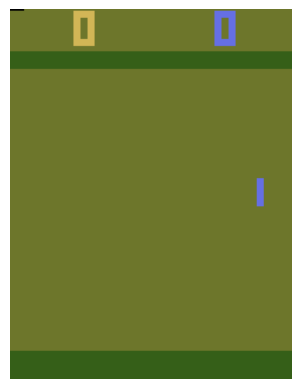

In [7]:
# Display the very first frame we grabbed.
plt.imshow(frames[0])
plt.axis("off")
plt.show()


Processed shape: (84, 84)


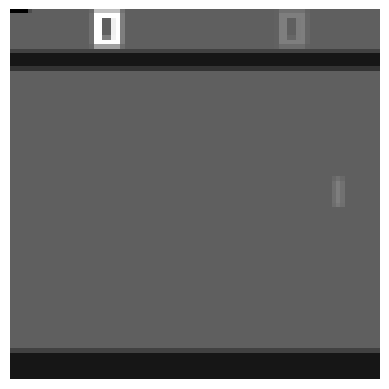

In [8]:
def preprocess_frame(frame):
    """
    Take a raw (210x160x3) RGB frame from Pong
    and convert it into a clean 84x84 grayscale image
    that the DQN can actually learn from.
    """

    # Turn the RGB frame into a grayscale image.
    gray = cv2.cvtColor(frame, cv2.COLOR_RGB2GRAY)

    # Shrink from (210x160) down to (84x84), which is the standard DQN input size.
    resized = cv2.resize(gray, (84, 84), interpolation=cv2.INTER_AREA)

    # Convert pixel values from 0–255 integers into 0–1 floats.
    normalized = resized.astype(np.float32) / 255.0

    return normalized


# Test the preprocessing on the first frame we collected earlier.
processed = preprocess_frame(frames[0])

print("Processed shape:", processed.shape)

# Show the processed grayscale image so we know it looks right.
plt.imshow(processed, cmap="gray")
plt.axis("off")
plt.show()


In [9]:
class FrameStack:
    """
    Keep a rolling window of the last N processed frames.
    This lets the agent see short-term motion instead of a single static image.
    """

    def __init__(self, num_frames=4):
        self.num_frames = num_frames
        self.frames = deque(maxlen=num_frames)

    def reset(self, initial_frame):
        """
        Called at the start of an episode.
        We take the very first raw frame, preprocess it,
        and then duplicate it N times so the stacked state is well-defined.
        """
        processed = preprocess_frame(initial_frame)

        self.frames.clear()
        for _ in range(self.num_frames):
            self.frames.append(processed)

        # Shape will be (num_frames, 84, 84)
        return np.stack(self.frames, axis=0)

    def step(self, new_frame):
        """
        Called every time we get a new raw frame from the environment.
        We preprocess it and push it into the stack, automatically
        dropping the oldest frame.
        """
        processed = preprocess_frame(new_frame)
        self.frames.append(processed)

        return np.stack(self.frames, axis=0)


In [10]:
# Make a fresh environment reset so we have a clean starting frame.
obs, info = env.reset()

# Create a frame stacker that holds the last 4 frames.
frame_stack = FrameStack(num_frames=4)

# Build the initial stacked state from the very first frame.
state = frame_stack.reset(obs)
print("Initial stacked state shape:", state.shape)  # expected: (4, 84, 84)

# Take a few random steps and update the frame stack.
for t in range(3):
    action = env.action_space.sample()
    obs, reward, terminated, truncated, info = env.step(action)
    state = frame_stack.step(obs)
    print(f"After step {t+1}, state shape:", state.shape)


Initial stacked state shape: (4, 84, 84)
After step 1, state shape: (4, 84, 84)
After step 2, state shape: (4, 84, 84)
After step 3, state shape: (4, 84, 84)


In [ ]:
class ReplayBuffer:
    """
    Simple experience replay buffer.
    Stores (state, action, reward, next_state, done) tuples.

    - state / next_state: stacked frames, shape (4, 84, 84)
    - action: integer INDEX into VALID_ACTIONS (0..NUM_ACTIONS-1)
    - reward: float
    - done: bool (True if the episode ended)
    """

    def __init__(self, capacity):
        # 'capacity' is the max number of transitions we keep.
        # Once we hit this limit, the oldest experiences get dropped.
        self.capacity = capacity
        self.buffer = deque(maxlen=capacity)

    def push(self, state, action, reward, next_state, done):
        """
        Save a single experience into the buffer.
        We store raw numpy arrays / values here.
        """
        self.buffer.append((state, action, reward, next_state, done))

    def sample(self, batch_size):
        """
        Randomly sample a batch of experiences.
        This is what the DQN will train on.
        """
        batch = random.sample(self.buffer, batch_size)

        # Unzip the batch into separate arrays.
        states, actions, rewards, next_states, dones = zip(*batch)

        # Convert to numpy arrays for easier handling later.
        states      = np.stack(states, axis=0)        # (batch, 4, 84, 84)
        next_states = np.stack(next_states, axis=0)   # (batch, 4, 84, 84)
        actions     = np.array(actions, dtype=np.int64)
        rewards     = np.array(rewards, dtype=np.float32)
        dones       = np.array(dones, dtype=np.float32)  # will be 0.0 or 1.0

        return states, actions, rewards, next_states, dones

    def __len__(self):
        """
        Let len(buffer) tell us how many experiences we have stored.
        This is handy for checking if we have enough to start training.
        """
        return len(self.buffer)


In [12]:
class DQN(nn.Module):
    """
    Convolutional Deep Q-Network for Pong.

    Input:  (batch, 4, 84, 84) stacked preprocessed frames
    Output: (batch, num_actions) predicted Q-values
    """

    def __init__(self, num_actions):
        super().__init__()

        # First block of convolutions extracts basic motion/edge features.
        self.conv1 = nn.Conv2d(4, 32, kernel_size=8, stride=4)

        # Second block extracts mid-level spatial features.
        self.conv2 = nn.Conv2d(32, 64, kernel_size=4, stride=2)

        # Third block captures more complex movement patterns.
        self.conv3 = nn.Conv2d(64, 64, kernel_size=3, stride=1)

        # The final size after these conv layers is 64 feature maps of size 7x7.
        self.fc1 = nn.Linear(64 * 7 * 7, 512)

        # Final layer outputs one Q-value per action.
        self.fc2 = nn.Linear(512, num_actions)

    def forward(self, x):
        # Convolution layers with ReLU activations.
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))

        # Flatten before fully-connected layers.
        x = x.view(x.size(0), -1)

        # Hidden layer + ReLU.
        x = F.relu(self.fc1(x))

        # Output layer: raw Q-values.
        return self.fc2(x)


In [24]:
# Device setup: use GPU if available, otherwise CPU.
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# Hyperparameters for DQN.
gamma = GAMMA          # discount factor for future rewards
batch_size = BATCH_SIZE       # how many experiences to sample per training step
learning_rate = LEARNING_RATE  # how fast we update the network weights

# Create both the policy network and the target network.
# - policy_net: the one we train on every step.
# - target_net: a slowly updated copy used to compute stable target values.
policy_net = DQN(num_actions=NUM_ACTIONS).to(device)
target_net = DQN(num_actions=NUM_ACTIONS).to(device)

# Copy the weights from policy_net -> target_net at the start.
target_net.load_state_dict(policy_net.state_dict())
target_net.eval()  # target_net is not trained directly, only updated by copying.

# Optimizer: Adam is a solid default choice for DQN.
optimizer = torch.optim.Adam(policy_net.parameters(), lr=learning_rate)


def optimize_model(replay_buffer, use_double_dqn=True):
    """
    Perform one gradient descent step on the DQN using a batch of
    experiences sampled from the replay buffer.

    If use_double_dqn is True, we use a Double DQN-style target to
    reduce maximisation bias:

        a* = argmax_a Q_policy(s', a)
        y  = r + gamma * Q_target(s', a*)

    Otherwise we fall back to the standard DQN target:

        y = r + gamma * max_a Q_target(s', a)
    """

    # We need at least 'batch_size' experiences before we can train.
    if len(replay_buffer) < batch_size:
        return None  # not enough data yet, skip the update

    # ---- 1. Sample a batch of experiences from the replay buffer ----
    states, actions, rewards, next_states, dones = replay_buffer.sample(batch_size)

    # Convert numpy arrays to PyTorch tensors and move them to the right device.
    states      = torch.from_numpy(states).to(device)          # (batch, 4, 84, 84)
    next_states = torch.from_numpy(next_states).to(device)     # (batch, 4, 84, 84)
    actions     = torch.from_numpy(actions).to(device)         # (batch,)
    rewards     = torch.from_numpy(rewards).to(device)         # (batch,)
    dones       = torch.from_numpy(dones).to(device)           # (batch,)

    # ---- 2. Compute Q(s, a) for the actions actually taken ----
    # policy_net(states) gives Q-values for ALL actions in each state: shape (batch, num_actions).
    q_values = policy_net(states)  # Q(s, ·)

    # We only want the Q-values for the specific actions we took.
    state_action_values = q_values.gather(1, actions.unsqueeze(1)).squeeze(1)  # Q(s, a_taken)

    # ---- 3. Compute target values ----
    with torch.no_grad():
        if use_double_dqn:
            # -------- Double DQN target --------
            # 1) Use the *policy* network to pick the best next action.
            next_q_policy = policy_net(next_states)                 # Q_policy(s', ·)
            best_next_actions = next_q_policy.argmax(dim=1)         # a* for each sample

            # 2) Use the *target* network to evaluate those actions.
            next_q_target = target_net(next_states)                 # Q_target(s', ·)
            max_next_q_values = next_q_target.gather(
                1, best_next_actions.unsqueeze(1)
            ).squeeze(1)                                           # Q_target(s', a*)
        else:
            # -------- Standard DQN target --------
            next_q_values = target_net(next_states)                 # Q_target(s', ·)
            max_next_q_values, _ = next_q_values.max(dim=1)        # max_a Q_target(s', a)

        # If done == 1, we don't bootstrap from the next state (no future reward).
        target_values = rewards + gamma * max_next_q_values * (1.0 - dones)

    # ---- 4. Compute the loss between current Q(s, a) and target values ----
    loss = F.mse_loss(state_action_values, target_values)

    # ---- 5. Backpropagation: update the policy network weights ----
    optimizer.zero_grad()  # clear old gradients
    loss.backward()        # compute new gradients
    optimizer.step()       # update the weights

    return loss.item()




Using device: cuda


In [ ]:
# This will track how many environment steps we've taken so far.
# We'll use it to slowly decay epsilon over time.
steps_done = 0

def get_epsilon(step):
    """
    Linearly decay epsilon from epsilon_start down to epsilon_end
    over 'epsilon_decay' steps.

    After that many steps, epsilon stays at epsilon_end.
    """
    if step >= EPSILON_DECAY:
        return EPSILON_END
    
    # Linear interpolation between start and end.
    fraction = step / EPSILON_DECAY
    return EPSILON_START + fraction * (EPSILON_END - EPSILON_START)


def select_action(state):
    """
    Choose an action using an epsilon-greedy policy over the
    REDUCED action set (VALID_ACTIONS).

    - The DQN outputs Q-values for action indices: 0, 1, 2
    - We map those indices to real Atari actions via VALID_ACTIONS.

    Returns:
        action_index: integer in [0, NUM_ACTIONS-1]
        env_action:   actual action ID to pass to env.step(...)
        epsilon:      current exploration rate (for logging)
    """
    global steps_done

    # Compute current epsilon based on how many steps we've taken.
    epsilon = get_epsilon(steps_done)
    steps_done += 1

    # Decide: explore or exploit?
    if np.random.rand() < epsilon:
        # Explore: pick a random INDEX into VALID_ACTIONS.
        action_index = np.random.randint(NUM_ACTIONS)
        env_action = VALID_ACTIONS[action_index]
        return action_index, env_action, epsilon

    # Exploit: choose best action index according to the current Q-network.
    # We need to turn state into a torch tensor with shape (1, 4, 84, 84).
    state_tensor = torch.from_numpy(state).unsqueeze(0).to(device)  # add batch dimension

    with torch.no_grad():
        q_values = policy_net(state_tensor)  # shape: (1, NUM_ACTIONS)
        action_index = int(torch.argmax(q_values, dim=1).item())

    env_action = VALID_ACTIONS[action_index]
    return action_index, env_action, epsilon


In [ ]:
# ============================================================
# Full Training Loop (Configurable)
# ------------------------------------------------------------
# This cell lets we train the DQN for a longer run, e.g., 500+
# episodes, with proper logging and target-network updates.
# For the assignment, we will likely run multiple sessions and
# compare plots.
# ============================================================

print("Training started at:", datetime.datetime.now())

# Reset counters and storage for a fresh training run.
steps_done = 0
episode_rewards = []

# Training configuration
num_episodes = NUM_EPISODES         
target_update_interval = TARGET_UPDATE_INTERVAL
max_steps_per_episode = MAX_STEPS_PER_EPISODE   # safety cutoff to avoid infinite loops

replay_buffer = ReplayBuffer(REPLAY_BUFFER_CAPACITY)

print("Starting training...\n")

for episode in range(1, num_episodes + 1):
    obs, info = env.reset()
    frame_stack = FrameStack(num_frames=4)
    state = frame_stack.reset(obs)

    episode_reward = 0.0
    done = False
    step = 0

    while not done and step < max_steps_per_episode:
        step += 1

        # Pick an action index based on epsilon-greedy policy.
        action_index, env_action, epsilon = select_action(state)

        # Interact with the environment using the actual env action.
        next_obs, reward, terminated, truncated, info = env.step(env_action)
        done = terminated or truncated

        # Update stacked frames → next state
        next_state = frame_stack.step(next_obs)

        # Save transition (we store the ACTION INDEX here).
        replay_buffer.push(state, action_index, reward, next_state, done)

        # Move forward
        state = next_state
        episode_reward += reward

        # Training step
        optimize_model(replay_buffer, use_double_dqn=USE_DOUBLE_DQN)

    episode_rewards.append(episode_reward)

    # Sync target network weights at intervals
    if episode % target_update_interval == 0:
        target_net.load_state_dict(policy_net.state_dict())

    # Episode summary
    print(
        f"Episode {episode:4d}/{num_episodes} | "
        f"Reward: {episode_reward:5.1f} | "
        f"Epsilon: {get_epsilon(steps_done):.3f} | "
        f"Buffer: {len(replay_buffer)}"
    )

print("\nTraining finished.")


Training started at: 2025-11-25 22:49:48.093881
Starting training...

Episode    1/800 | Reward: -18.0 | Epsilon: 0.996 | Buffer: 4809
Episode    2/800 | Reward: -21.0 | Epsilon: 0.993 | Buffer: 7977
Episode    3/800 | Reward: -19.0 | Epsilon: 0.989 | Buffer: 11838
Episode    4/800 | Reward: -21.0 | Epsilon: 0.986 | Buffer: 15134
Episode    5/800 | Reward: -20.0 | Epsilon: 0.983 | Buffer: 18808
Episode    6/800 | Reward: -20.0 | Epsilon: 0.980 | Buffer: 22292
Episode    7/800 | Reward: -20.0 | Epsilon: 0.976 | Buffer: 26255
Episode    8/800 | Reward: -20.0 | Epsilon: 0.973 | Buffer: 29865
Episode    9/800 | Reward: -20.0 | Epsilon: 0.969 | Buffer: 33932
Episode   10/800 | Reward: -21.0 | Epsilon: 0.966 | Buffer: 37820
Episode   11/800 | Reward: -20.0 | Epsilon: 0.963 | Buffer: 41433
Episode   12/800 | Reward: -20.0 | Epsilon: 0.960 | Buffer: 44803
Episode   13/800 | Reward: -20.0 | Epsilon: 0.956 | Buffer: 48590
Episode   14/800 | Reward: -18.0 | Epsilon: 0.952 | Buffer: 53111
Episode 

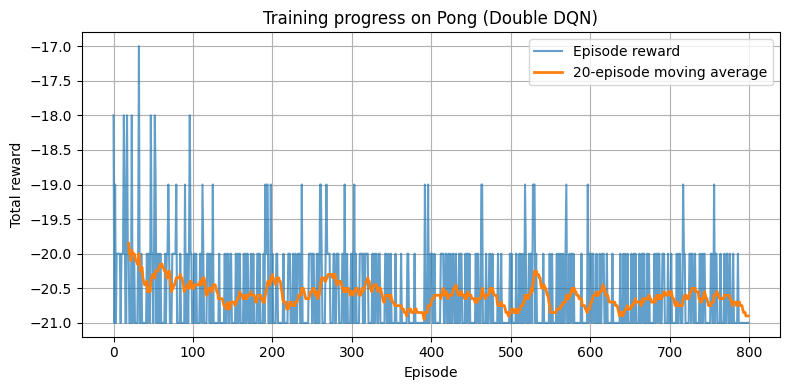

First 10 rewards: [-18.0, -21.0, -19.0, -21.0, -20.0, -20.0, -20.0, -20.0, -20.0, -21.0]
Last 10 rewards: [-21.0, -21.0, -21.0, -21.0, -21.0, -21.0, -21.0, -21.0, -21.0, -21.0]


In [19]:
# ============================================================
# Reward curve for training run
# ------------------------------------------------------------
# Visualise how the total episode reward changed over time.
# ============================================================

plt.figure(figsize=(8, 4))

# Plot raw episode rewards.
plt.plot(episode_rewards, label="Episode reward", alpha=0.7)

# Add a simple moving average to smooth the curve a bit.
if len(episode_rewards) >= 20:
    window = 20
    moving_avg = np.convolve(
        episode_rewards,
        np.ones(window) / window,
        mode="valid"
    )
    plt.plot(
        range(window - 1, len(episode_rewards)),
        moving_avg,
        label=f"{window}-episode moving average",
        linewidth=2
    )

plt.xlabel("Episode")
plt.ylabel("Total reward")
plt.title("Training progress on Pong (Double DQN)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

print("First 10 rewards:", episode_rewards[:10])
print("Last 10 rewards:", episode_rewards[-10:])


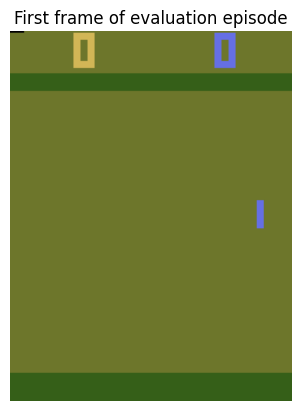

Evaluation episode finished. Total reward: -21.0
Number of frames collected: 3056


In [ ]:

def run_evaluation_episode(render_first_frame=True):
    """
    Run a single evaluation episode using a purely greedy policy
    (no random exploration) over the REDUCED action set.

    Returns the total reward and the list of raw RGB frames.
    """

    policy_net.eval()  # disable training-specific behaviour

    # Reset the environment and frame stack.
    obs, info = env.reset()
    frame_stack = FrameStack(num_frames=4)
    state = frame_stack.reset(obs)

    done = False
    total_reward = 0.0
    frames_eval = []  # store frames here if we want to turn them into a video later

    while not done:
        # Convert state to a batch of size 1.
        state_tensor = torch.from_numpy(state).unsqueeze(0).to(device)

        # Greedy action selection over indices 0..NUM_ACTIONS-1.
        with torch.no_grad():
            q_values = policy_net(state_tensor)          # shape: (1, NUM_ACTIONS)
            action_index = int(torch.argmax(q_values, dim=1).item())

        env_action = VALID_ACTIONS[action_index]

        # Step the env with the chosen action.
        next_obs, reward, terminated, truncated, info = env.step(env_action)
        done = terminated or truncated

        # Update frame stack and accumulate reward.
        state = frame_stack.step(next_obs)
        total_reward += reward

        # Save the raw frame for possible video export later.
        frames_eval.append(next_obs)

    # Optionally show the very first frame of the evaluation run.
    if render_first_frame and len(frames_eval) > 0:
        plt.imshow(frames_eval[0])
        plt.axis("off")
        plt.title("First frame of evaluation episode")
        plt.show()

    print(f"Evaluation episode finished. Total reward: {total_reward:.1f}")
    print(f"Number of frames collected: {len(frames_eval)}")

    return total_reward, frames_eval


# ---- Quick smoke test: run one evaluation episode ----
eval_reward, eval_frames = run_evaluation_episode(render_first_frame=True)


In [25]:
def inspect_policy_actions():
    """
    Run a single greedy-policy episode and count how many times
    each action INDEX (0..NUM_ACTIONS-1) is chosen.

    This helps debug collapse to a single action like 'always UP'.
    """

    policy_net.eval()  # make sure we're in eval mode

    # Reset environment and frame stack
    obs, info = env.reset()
    frame_stack = FrameStack(num_frames=4)
    state = frame_stack.reset(obs)

    done = False
    total_reward = 0.0

    # One counter per possible ACTION INDEX (not raw env action!
    action_counts = np.zeros(NUM_ACTIONS, dtype=int)

    while not done:
        state_tensor = torch.from_numpy(state).unsqueeze(0).to(device)

        # Greedy over indices 0..NUM_ACTIONS-1
        with torch.no_grad():
            q_values = policy_net(state_tensor)
            action_index = int(torch.argmax(q_values, dim=1).item())

        env_action = VALID_ACTIONS[action_index]
        action_counts[action_index] += 1

        next_obs, reward, terminated, truncated, info = env.step(env_action)
        done = terminated or truncated

        state = frame_stack.step(next_obs)
        total_reward += reward

    print("Inspection episode total reward:", total_reward)
    print("Action counts per ACTION INDEX (mapped via VALID_ACTIONS):")
    for i in range(NUM_ACTIONS):
        print(f"  index {i} (env action {VALID_ACTIONS[i]}): {action_counts[i]} steps")

# ---- Run the action inspection ---
inspect_policy_actions()


Inspection episode total reward: -21.0
Action counts per ACTION INDEX (mapped via VALID_ACTIONS):
  index 0 (env action 0): 3056 steps
  index 1 (env action 2): 0 steps
  index 2 (env action 3): 0 steps


In [18]:
def save_video(frames, filename="pong_evaluation.mp4", fps=30):
    """
    Save a list of RGB frames (H, W, 3) as a video file using OpenCV.

    - frames: list of numpy arrays from the environment (RGB).
    - filename: output video file name.
    - fps: frames per second for the video.
    """

    if len(frames) == 0:
        print("No frames to save, skipping video.")
        return

    # Get frame height and width from the first frame.
    height, width, _ = frames[0].shape

    # FourCC code for mp4 output; should work on most setups.
    fourcc = cv2.VideoWriter_fourcc(*"mp4v")
    video_writer = cv2.VideoWriter(filename, fourcc, fps, (width, height))

    for frame in frames:
        # OpenCV expects BGR, but Gym gives RGB.
        bgr_frame = cv2.cvtColor(frame, cv2.COLOR_RGB2BGR)
        video_writer.write(bgr_frame)

    video_writer.release()
    print(f"Video saved to: {filename}")


# Use the frames from the last evaluation run.
save_video(eval_frames, filename="pong_evaluation.mp4", fps=30)


Video saved to: pong_evaluation.mp4
